# Training ML models using an Annotated Grain Kernel Image Database

Our group chose a Grain Kernel database as our data for training 3 machine learning models in the MCO. In order to prepare the dataset for the training, we will first make sure that the dataset is clean and uniform (i.e. No duplicate files, uniform aspect ratios, etc).

In [18]:
%pip install Pillow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import os
from PIL import Image

### Verify file integrity
We will check if every images are accessible and not corrupted

ps: the dataset is not included in git, it should be structured as 
/dataset/images where the maize and rice datasets are in the /images path and the xml files are in /dataset

In [20]:
data_dir = "./dataset/images"
extensions = ".png"

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(extensions):
            img_path = os.path.join(root, file)
            try:
                img = Image.open(img_path)
                img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Corrupt image or wrong extension: {img_path}")

### Verify XML Annotations Match Existing Images

Check if every entry in the XML files has a corresponding image file in the dataset.

In [22]:
import xml.etree.ElementTree as ET
from pathlib import Path


def check_xml_images(xml_file, grain_type):
    """Check if all XML entries have corresponding images"""

    tree = ET.parse(xml_file)
    root = tree.getroot()

    xml_ids = []
    for obj in root.findall("object"):
        id_elem = obj.find("ID")
        if id_elem is not None:
            xml_ids.append(id_elem.text)

    # Build list of all actual image files
    image_dir = Path(f"./dataset/images/{grain_type}")
    actual_images = set()

    for img_path in image_dir.rglob("*.png"):
        # Get filename without extension
        actual_images.add(img_path.stem)

    # Find missing images
    missing_images = []
    for xml_id in xml_ids:
        if xml_id not in actual_images:
            missing_images.append(xml_id)

    # Report results
    print(f"Results for {grain_type.upper()}")
    print(f"Total XML entries: {len(xml_ids)}")
    print(f"Missing images: {len(missing_images)}")

    return len(missing_images)


# Check both maize and rice
total_missing = 0
total_missing += check_xml_images("./dataset/maize.xml", "maize")
total_missing += check_xml_images("./dataset/rice.xml", "rice")

Results for MAIZE
Total XML entries: 19000
Missing images: 0
Results for RICE
Total XML entries: 30962
Missing images: 0


# Exploratory Data Analysis

We will analysis the trands and characteristics of the dataset.

Let us first see the distribution of the images for the different categories for each of the grains.

In [23]:
%pip install pandas matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from PIL import Image

In [38]:
# Define disease categories for each grain type
MAIZE_CATEGORIES = ["0_NOR", "1_F&S", "2_SD", "3_MY", "4_AP", "5_BN", "6_HD", "7_IM"]
RICE_CATEGORIES = ["0_NOR", "1_F&S", "2_SD", "3_MY", "4_AP", "5_BN", "6_UN", "7_IM"]

CATEGORIES_MAP = {"maize": MAIZE_CATEGORIES, "rice": RICE_CATEGORIES}

# Count images in each category
base_dir = "./dataset/images"
image_distribution = {}

grain_types = ["maize", "rice"]
splits = ["train", "test"]

for grain in grain_types:
    image_distribution[grain] = {}
    categories = CATEGORIES_MAP[grain]

    for split in splits:
        split_path = os.path.join(base_dir, grain, split)

        if not os.path.exists(split_path):
            print(f"Warning: {split_path} does not exist")
            continue

        image_distribution[grain][split] = {}

        for category in categories:
            category_path = os.path.join(split_path, category)

            image_count = len(
                [f for f in os.listdir(category_path) if f.lower().endswith(".png")]
            )

            image_distribution[grain][split][category] = image_count

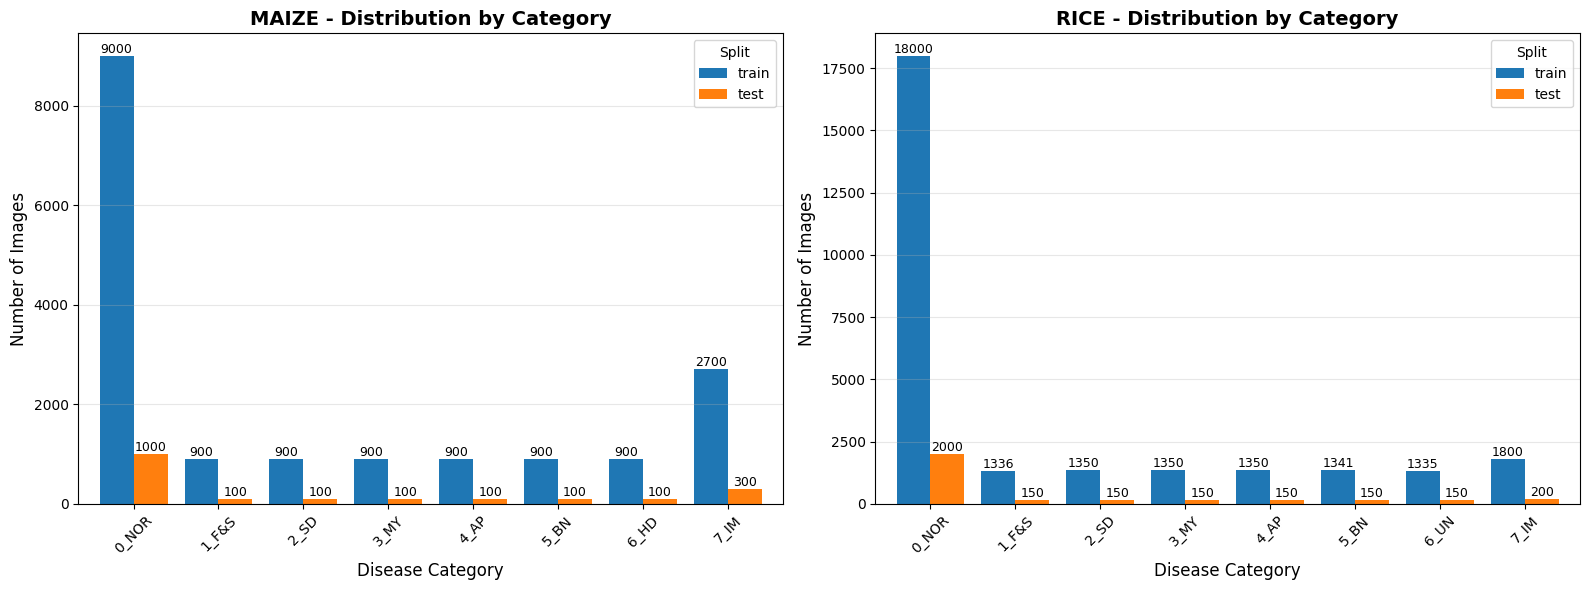

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, grain in enumerate(["maize", "rice"]):
    df = pd.DataFrame(image_distribution[grain])

    df.plot(kind="bar", ax=axes[idx], width=0.8)

    axes[idx].set_title(
        f"{grain.upper()} - Distribution by Category",
        fontsize=14,
        fontweight="bold",
    )
    axes[idx].set_xlabel("Disease Category", fontsize=12)
    axes[idx].set_ylabel("Number of Images", fontsize=12)
    axes[idx].legend(title="Split", fontsize=10)
    axes[idx].grid(axis="y", alpha=0.3)

    # Rotate x-axis labels for readability
    axes[idx].tick_params(axis="x", rotation=45)

    # Add value labels on bars
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt="%d", fontsize=9)

plt.tight_layout()
plt.show()

The, we create a tool that can examine a single grain image and uncover its characteristics. This tool acts like a digital scanner that measures the grain’s dimensions and captures its average color while ignoring the dark background.

In [34]:
def extract_grain_features_pil(img_path):
    with Image.open(img_path) as img:
        # Dimensions using bounding box of non-zero pixels
        grayscale = img.convert('L')
        bbox = grayscale.getbbox() 
        
        if bbox:
            left, top, right, bottom = bbox
            width = right - left
            height = bottom - top
            aspect_ratio = width / height if height > 0 else 0
        else:
            width, height, aspect_ratio = 0, 0, 0
        
        # Calculate Average Color (RGB)
        img_rgb = img.convert('RGB')
        arr = np.array(img_rgb)
        pixels = arr.reshape(-1, 3)
        
        # Filter background
        mask = np.any(pixels > 20, axis=1) 
        foreground = pixels[mask]
        
        if len(foreground) > 0:
            mean_color = foreground.mean(axis=0)
        else:
            mean_color = [0, 0, 0]
            
        return {
            'width': width,
            'height': height,
            'aspect_ratio': aspect_ratio,
            'mean_r': mean_color[0],
            'mean_g': mean_color[1],
            'mean_b': mean_color[2]
        }

Once the scanner is ready, we apply it to the dataset in a systematic way. Rather than analyzing every image, we perform a statistical survey by sampling 300 images from each category. This approach provides enough data to reveal meaningful patterns while keeping the analysis efficient.

In [35]:
features_list = []
# Sample 300 images from each category for the analysis
sample_size = 300 

for grain in ["maize", "rice"]:
    categories = CATEGORIES_MAP[grain]
    for cat in categories:
        path = os.path.join(base_dir, grain, "train", cat)
        if not os.path.exists(path):
            continue
            
        images = [f for f in os.listdir(path) if f.lower().endswith(".png")]
        sample = random.sample(images, min(len(images), sample_size))
        
        for img_name in sample:
            img_path = os.path.join(path, img_name)
            stats = extract_grain_features_pil(img_path)
            stats.update({'grain': grain, 'category': cat})
            features_list.append(stats)

feat_df = pd.DataFrame(features_list)

Finally, we visualize the data to answer key questions:

- Does the disease change the shape of the kernel?

- Does the disease change the color of the kernel?

If we see clear distinctions in these graphs, we know our Machine Learning model will likely perform well.

C:\Users\ed\AppData\Local\Temp\ipykernel_12508\2220514054.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=grain_data, x='category', y='aspect_ratio', ax=axes[0], palette="Set2")
C:\Users\ed\AppData\Local\Temp\ipykernel_12508\2220514054.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=grain_data, x='category', y='area', palette="Set3")


--------------------------------------------------------------------------------


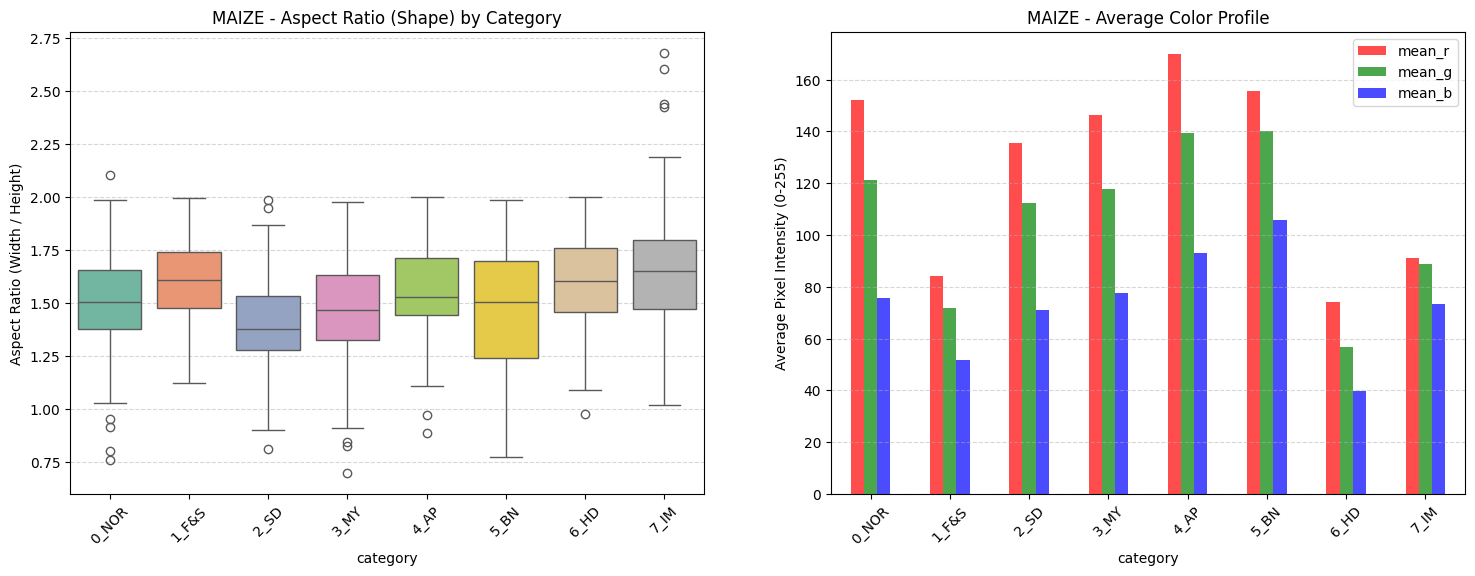

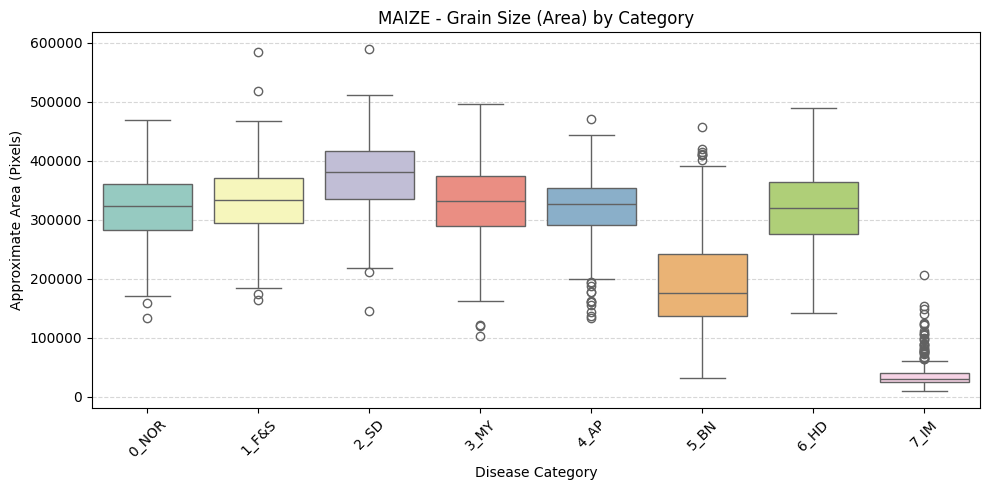

C:\Users\ed\AppData\Local\Temp\ipykernel_12508\2220514054.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=grain_data, x='category', y='aspect_ratio', ax=axes[0], palette="Set2")
C:\Users\ed\AppData\Local\Temp\ipykernel_12508\2220514054.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=grain_data, x='category', y='area', palette="Set3")


--------------------------------------------------------------------------------


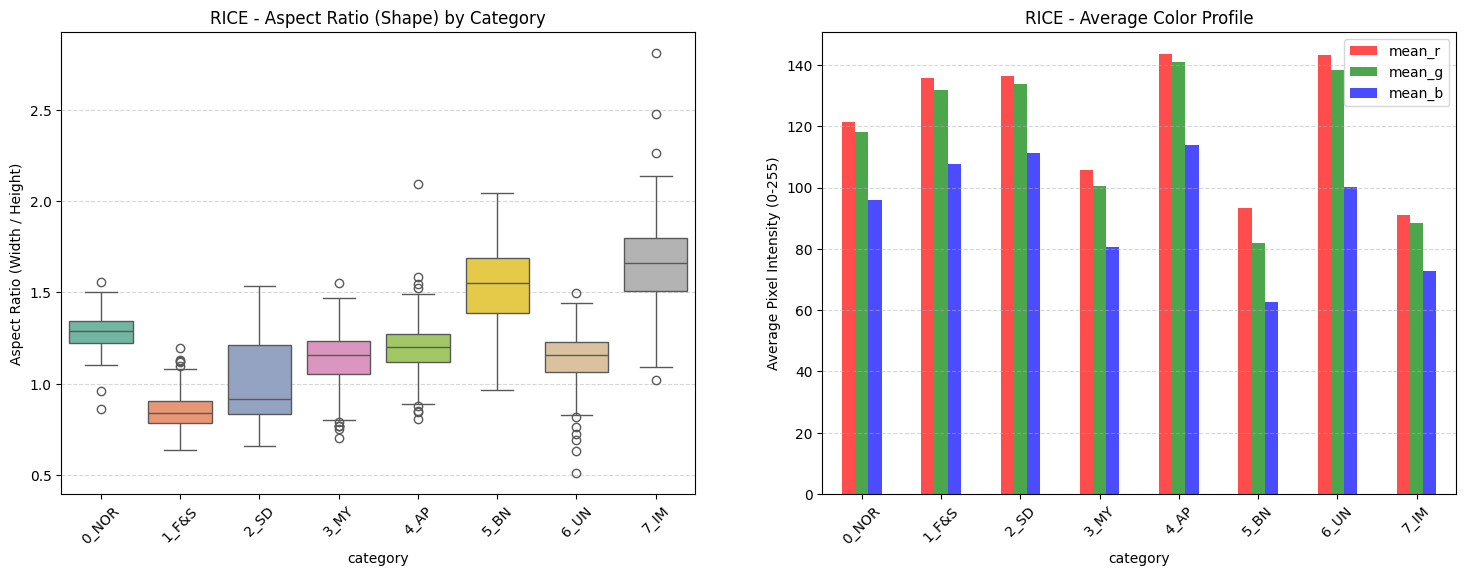

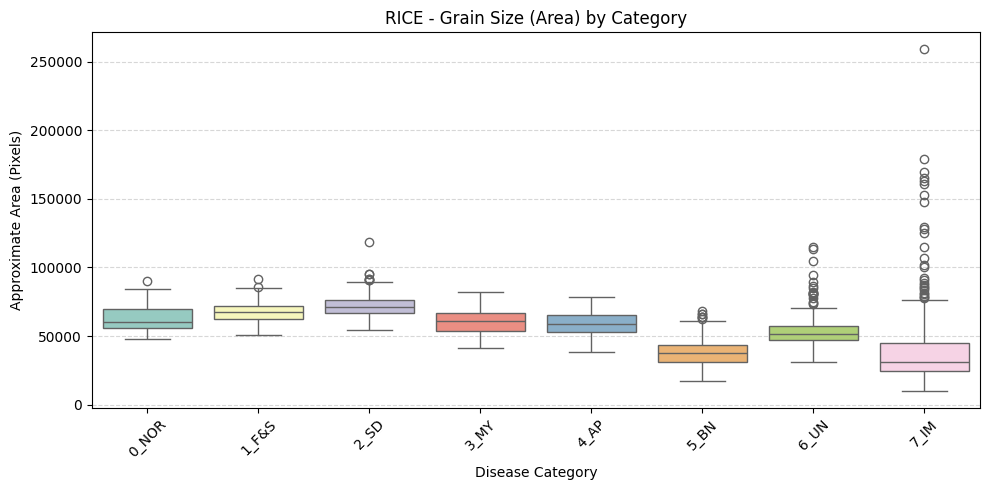

In [ ]:
# Calculate area of the size of the grain
feat_df['area'] = feat_df['width'] * feat_df['height']

for grain in ["maize", "rice"]:
    grain_data = feat_df[feat_df['grain'] == grain]
    if grain_data.empty: continue
        
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # We use a boxplot to see if diseases cause the grain to shrivel or deform
    sns.boxplot(data=grain_data, x='category', y='aspect_ratio', ax=axes[0], palette="Set2")
    axes[0].set_title(f"{grain.upper()} - Aspect Ratio (Shape) by Category")
    axes[0].set_ylabel("Aspect Ratio (Width / Height)")
    axes[0].tick_params(axis="x", rotation=45)
    axes[0].grid(axis='y', linestyle='--', alpha=0.5)
    
    # Average Red, Green, and Blue intensity
    color_stats = grain_data.groupby('category')[['mean_r', 'mean_g', 'mean_b']].mean()
    color_stats.plot(kind='bar', ax=axes[1], color=['red', 'green', 'blue'], alpha=0.7)
    axes[1].set_title(f"{grain.upper()} - Average Color Profile")
    axes[1].set_ylabel("Average Pixel Intensity (0-255)")
    axes[1].tick_params(axis="x", rotation=45)
    axes[1].grid(axis='y', linestyle='--', alpha=0.5)

    # Size of the grains
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=grain_data, x='category', y='area', palette="Set3")
    plt.title(f"{grain.upper()} - Grain Size (Area) by Category")
    plt.ylabel("Approximate Area (Pixels)")
    plt.xlabel("Disease Category")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    print("-" * 80)
    
    plt.tight_layout()
    plt.show()

The dataset reveals distinct physical and chromatic patterns across both grain categories, confirming that the data contains separable features suitable for machine learning classification.

For maize, aspect ratios remain fairly consistent (medians $\approx$ 1.5) across categories, though diseased classes exhibit significant outlier spread which indicates shape irregularity. Grain size proves to be a stronger discriminator, with Immature (IM) and Broken (BN) grains showing drastically reduced areas compared to the stable dimensions of other groups. Chromatically, maize categories are clearly distinguishable, as Heat Damaged (HD), Fusarium (F&S), and Impurities (IM) samples appear noticeably darker.

In contrast, rice aspect ratios vary more distinctly due to differences in elongation. Color profiling successfully isolates darker Moldy (MY), Broken (BN), and Impurities (IM) grains from brighter categories like Unripe (UN). These distinct geometric and chromatic patterns confirm that the dataset contains separable features suitable for robust classification.